In [1]:
import matplotlib.pyplot as plt 
import os 
import torch
import numpy as np
import torch.nn as nn
from typing import List, Tuple, Optional
import matplotlib.pyplot as plt
import random 
from decimal import Decimal
import deepwave
import warnings
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from functools import partial
import time
warnings.filterwarnings('ignore')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
gpu_count = torch.cuda.device_count()
print(f"The number of available GPUs is: {gpu_count}")
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")  
    print(f"The selected GPU device is: {torch.cuda.get_device_name(DEVICE)}")
else:
    DEVICE = torch.device("cpu")
    print("No available GPUs detected, switched to using CPU")

The number of available GPUs is: 4
The selected GPU device is: NVIDIA GeForce RTX 3080 Ti


# Define functions

In [3]:
#export CUBLAS_WORKSPACE_CONFIG=:16:8
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
def seed_everything(seed=42):  
    """
    Random seeds in fixed code are easy to reproduce
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)
def Downsample(img,aim_height,aim_width):
    channel,height,width = img.shape   
    empty_img = torch.zeros((channel,aim_height,aim_width))  
    transform_h = aim_height/height 
    transform_w = aim_width/width   
    for i in range(aim_height):
        for j in range(aim_width):
            x = int(i/transform_h) 
            y = int(j/transform_w)
            empty_img[:,i,j]=img[:,x,y] 
    return empty_img
def awgn(x_volt, snr):
    """

    https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python

    """
    if snr != 0:
            x_watts = x_volt ** 2
            sig_avg_watts = torch.mean(x_watts)

            sig_avg_db = 10 * torch.log10(sig_avg_watts)

            noise_avg_db = sig_avg_db - snr
            noise_avg_watts = 10 ** (noise_avg_db / 10)

            mean_noise = 0

            noise = torch.normal(mean_noise, torch.sqrt(noise_avg_watts), x_watts.shape)
            x_volt += noise

    return x_volt
def get_dir(directory):
    """
    Creates the given directory if it does not exist.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def clear_dir(directory):
    """
    Removes all files in the given directory.
    """
    if not os.path.isdir(directory): raise Exception("%s is not a directory"%(directory))
    if type(directory) != str: raise Exception("string type required for directory: %s"%(directory))
    if directory in ["..",".", "","/","./","../","*"]: raise Exception("trying to delete current directory, probably bad idea?!")
    
    for f in os.listdir(directory):
        path = os.path.join(directory, f)
        try:
            if os.path.isfile(path):
                os.remove(path)
            elif os.path.isdir(path):
                shutil.rmtree(path)
        except Exception as e:
            print(e)

# ViT reparameterization

In [4]:
## 卷积定义
class SubBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(SubBlock, self).__init__()
        self.conv = self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                      kernel_size=3, stride=stride, padding=1,
                      bias=True,
                    #   padding_mode="reflect"  # Help to reduce the artifacts
                      ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.conv(x)

#卷积块
class Eblock(nn.Module):
    def __init__(self, in_channels, out_channels, stride, operation, final_shape=None):
        super(Eblock, self).__init__()
        layers = [
            SubBlock(in_channels=in_channels,
                              out_channels=out_channels,
                              stride=stride),
            SubBlock(in_channels=out_channels,
                              out_channels=out_channels,
                              stride=stride)
            ]
        if operation == "down":
            layers.append(
                nn.MaxPool2d(kernel_size=2)
            )
        elif operation == "up":
            if not final_shape:
                layers.append(
                    nn.Upsample(scale_factor=2, mode="bilinear")
                )
            else:
                layers.append(
                    nn.Upsample(final_shape, mode="bilinear")
                )
            
        self.layers = nn.Sequential(*layers)
    def forward(self, x):
        out = self.layers(x)
        #print('shape',out.shape)
        return out  

# 1.特征融合
class Fusion(nn.Module):
    def __init__(self,in_channels):
        super(Fusion, self).__init__()
        self.vconv = nn.Conv2d(in_channels=in_channels, out_channels=1,
                      kernel_size=1, stride=1)
        self.fconv = nn.Conv2d(in_channels=2, out_channels=1,
                      kernel_size=1, stride=1)
    def forward(self,xp,xs):
        if xp.shape != xs.shape:
            print("Vp=%s is not equal to Vs=%s"%(xp.shape,xs.shape))
        else:
            xp = self.vconv(xp)
            xs = self.vconv(xs)
            v = torch.cat((xp,xs),dim=1)
            x = self.fconv(v)
            return x

# 2. transformer 编码器
def drop_path(x, drop_prob: float = 0., training: bool = False):

    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class PatchEmbed(nn.Module):
    def __init__(self, nt, nr, patch_size=(16,16), embed_dim=768, norm_layer=None):
        super().__init__()
        patch_size = patch_size
        self.nt= nt
        self.nr= nr
        self.patch_size = patch_size
        self.grid_size = (nt // patch_size[0], nr // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        B, C, H, W = x.shape      
        x = self.proj(x).flatten(2).transpose(1, 2)   
        x = self.norm(x)
        return x

class Attention(nn.Module):
    def __init__(self,
                 dim,   
                 num_heads=8,
                 qkv_bias=False,
                 qk_scale=None,
                 attn_drop_ratio=0.,
                 proj_drop_ratio=0.):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop_ratio)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop_ratio)

    def forward(self, x):
        B, N, C = x.shape

        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)


        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

#Encoder Block中的MLP Block
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

#一个Encoder Block
class Block(nn.Module):
    def __init__(self,
                 dim,   
                 num_heads,
                 mlp_ratio=4.,   
                 qkv_bias=False,
                 qk_scale=None,
                 drop_ratio=0.,
                 attn_drop_ratio=0.,
                 drop_path_ratio=0.,   
                 act_layer=nn.GELU,
                 norm_layer=nn.LayerNorm):
        super(Block, self).__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
                              attn_drop_ratio=attn_drop_ratio, proj_drop_ratio=drop_ratio)   
        self.drop_path = DropPath(drop_path_ratio) if drop_path_ratio > 0. else nn.Identity()  
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop_ratio)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# 3. 卷积解码模块
class Decoder_vp(nn.Module):
    def __init__(self, batch_size,
                 initial_shape: Tuple, 
                 final_shape: Tuple,
                 n_blocks,
                 final_out_channels=1
                 ):
        
        super(Decoder_vp, self).__init__() 
        self._set_initial_shape(initial_shape) 
        self.batch_size = batch_size
        finalize = None
        
        layers = []
        
        self.out_channels = [8*(2 ** i) for i in range(n_blocks)]
        self.out_channels = sorted(self.out_channels, reverse=True)
        layers.append(
            Eblock(in_channels = 1,out_channels=self.out_channels[0], stride=1, operation="up"))
        
        for layer_idx in range(n_blocks-1):
            finalize = final_shape if  layer_idx== n_blocks-2 else None
                        
            layers.append(
                Eblock(in_channels=self.out_channels[layer_idx],
                      out_channels=self.out_channels[layer_idx + 1],
                      stride=1, operation="up",
                      final_shape=finalize
                      )
                )
            
        self.conv_layers = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels[-1],
                      out_channels=final_out_channels, 
                      kernel_size=3, padding=1, stride=1,
                      bias=True
                      )
            
            )
    def _set_initial_shape(self, initial_shape_decoder: Tuple):
        self.initial_shape = initial_shape_decoder
    def _set_finale_shape(self, final_shape_decoder: Tuple):
        self.conv_layers[-1].layers[2].size = final_shape_decoder  
    def forward(self, x):
        x = x.reshape(self.batch_size, 1, self.initial_shape[0], self.initial_shape[1])
        out_vp = self.conv_layers(x)
        out_vp = self.final(out_vp)
        return out_vp

class Decoder_vs(nn.Module):
    def __init__(self, batch_size,
                 initial_shape: Tuple, 
                 final_shape: Tuple,
                 n_blocks,
                 final_out_channels=1
                 ):
        
        super(Decoder_vs, self).__init__() 
        self._set_initial_shape(initial_shape) 
        self.batch_size = batch_size
        finalize = None
        
        layers = []
        
        self.out_channels = [8*(2 ** i) for i in range(n_blocks)]
        self.out_channels = sorted(self.out_channels, reverse=True)
        layers.append(
            Eblock(in_channels = 1,out_channels=self.out_channels[0], stride=1, operation="up"))
        
        for layer_idx in range(n_blocks-1):
            finalize = final_shape if  layer_idx== n_blocks-2 else None
                        
            layers.append(
                Eblock(in_channels=self.out_channels[layer_idx],
                      out_channels=self.out_channels[layer_idx + 1],
                      stride=1, operation="up",
                      final_shape=finalize
                      )
                )
            
        self.conv_layers = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels[-1],
                      out_channels=final_out_channels, 
                      kernel_size=3, padding=1, stride=1,
                      bias=True
                      )
            
            )
    def _set_initial_shape(self, initial_shape_decoder: Tuple):
        self.initial_shape = initial_shape_decoder
    def _set_finale_shape(self, final_shape_decoder: Tuple):
        self.conv_layers[-1].layers[2].size = final_shape_decoder  
    def forward(self, x):
        x = x.reshape(self.batch_size, 1, self.initial_shape[0], self.initial_shape[1])
        out_vs = self.conv_layers(x)
        out_vs = self.final(out_vs)
        return out_vs

class Decoder_rho(nn.Module):
    def __init__(self, batch_size,
                 initial_shape: Tuple, 
                 final_shape: Tuple,
                 n_blocks,
                 final_out_channels=1
                 ):
        
        super(Decoder_rho, self).__init__() 
        self._set_initial_shape(initial_shape) 
        self.batch_size = batch_size
        finalize = None
        
        layers = []
        
        self.out_channels = [8*(2 ** i) for i in range(n_blocks)]
        self.out_channels = sorted(self.out_channels, reverse=True)
        layers.append(
            Eblock(in_channels = 1,out_channels=self.out_channels[0], stride=1, operation="up"))
        
        for layer_idx in range(n_blocks-1):
            finalize = final_shape if  layer_idx== n_blocks-2 else None
                        
            layers.append(
                Eblock(in_channels=self.out_channels[layer_idx],
                      out_channels=self.out_channels[layer_idx + 1],
                      stride=1, operation="up",
                      final_shape=finalize
                      )
                )
        self.conv_layers = nn.Sequential(*layers)
        self.final = nn.Sequential(
            nn.Conv2d(in_channels=self.out_channels[-1],
                      out_channels=final_out_channels, 
                      kernel_size=3, padding=1, stride=1,
                      bias=True
                      )
            
            )

    def _set_initial_shape(self, initial_shape_decoder: Tuple):
        self.initial_shape = initial_shape_decoder
    def _set_finale_shape(self, final_shape_decoder: Tuple):
        self.conv_layers[-1].layers[2].size = final_shape_decoder  
    def forward(self, x):
        x = x.reshape(self.batch_size, 1, self.initial_shape[0], self.initial_shape[1])
        out_rho = self.conv_layers(x)
        out_rho = self.final(out_rho)
        return out_rho

class Transfomerdecoder(nn.Module):
    def __init__(self,batch_size,in_channels,nt,nr,patch_size=(16,16), embed_dim=768,transddepth=12,n_blocks_decoder=4,final_size_encoder=98,
               initial_shape_decoder=[14,28],final_spatial_shape=[116, 227],num_heads=12, mlp_ratio=4.0, qkv_bias=True,qk_scale=None, 
               drop_ratio=0.,attn_drop_ratio=0., drop_path_ratio=0., embed_layer=PatchEmbed, norm_layer=None,
               act_layer=None):
        super(Transfomerdecoder,self).__init__()
        
        self.H_v = nt//patch_size[0]
        self.W_v = nr//patch_size[1]
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU
        self.fusion = Fusion(in_channels)
        self.patch_embed = embed_layer(nt,nr, patch_size=patch_size, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches , embed_dim))     
        self.pos_drop = nn.Dropout(p=drop_ratio)
        dpr = [x.item() for x in torch.linspace(0, drop_path_ratio, transddepth)]
        self.blocks = nn.Sequential(*[
            Block(dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                  drop_ratio=drop_ratio, attn_drop_ratio=attn_drop_ratio, drop_path_ratio=dpr[i],
                  norm_layer=norm_layer, act_layer=act_layer)
            for i in range(n_blocks_decoder)])
        self.norm = norm_layer(embed_dim)  
        self.relu= F.relu
        self.fc_in_features = 1 * embed_dim * self.H_v * self.W_v
        self.final = nn.Sequential(nn.Linear(in_features=self.fc_in_features, out_features=final_size_encoder))
        self.decoder_vp = Decoder_vp(batch_size, initial_shape=initial_shape_decoder,
                               final_shape=final_spatial_shape, n_blocks=n_blocks_decoder, 
                               final_out_channels=1)
        self.decoder_vs = Decoder_vs(batch_size, initial_shape=initial_shape_decoder,
                               final_shape=final_spatial_shape, n_blocks=n_blocks_decoder, 
                               final_out_channels=1) 
        self.decoder_rho = Decoder_rho(batch_size, initial_shape=initial_shape_decoder,
                               final_shape=final_spatial_shape, n_blocks=n_blocks_decoder, 
                               final_out_channels=1) 
    def forward(self,xx,yy):
        x = self.fusion(xx,yy)
        x = self.patch_embed(x)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        B,C,H,W = x.shape[0],x.shape[2],int(self.H_v),int(self.W_v)
        x = x.reshape(B,C,H,W)
        x = x.view(-1)
        x = self.final(x)
        vp = self.decoder_vp(x)
        vs = self.decoder_vs(x)
        rho = self.decoder_rho(x)
        return vp,vs,rho

# RNN-based EFWI (Deepwave)

In [5]:
class Physics_deepwave(nn.Module):
    def __init__(self, dh, dt, F_PEAK,size,
                 src,src_loc, rec_loc,rp_properties=None):
        super(Physics_deepwave, self).__init__()
        self.dh = dh
        self.dt = dt
        self.src = src
        self.src_loc = src_loc
        self.rec_loc = rec_loc
        self.F_PEAK = F_PEAK
        self.size = size
        rp_properties = rp_properties
    
    def forward(self, vp,vs,rho):
        out = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp, vs,rho),
            self.dh, self.dt,
            source_amplitudes_y=self.src,
            source_amplitudes_x=self.src,
            source_locations_y=self.src_loc,
            source_locations_x=self.src_loc,
            receiver_locations_y=self.rec_loc,
            receiver_locations_x=self.rec_loc,
            pml_freq=self.F_PEAK
            )
        vx = out[15]
        vy = out[14]
        return vx.permute(0, 2, 1).unsqueeze(0),vy.permute(0, 2, 1).unsqueeze(0)

# ViT-EFWI

In [6]:
def train_deepwave(Physics, 
                   transfomerdecoder, 
                   deepwave_size,
                   rho_initial,
                   vx_initial,
                   vy_initial,
                   d_obs_vx,
                   d_obs_vy,
                   input_vx,
                   input_vy,
                   optim_transfomerdecoder, 
                   criteria, 
                   mini_batches,
                   src_loc, 
                   rec_loc, 
                   src, 
                   inpa,
                   submarine,
                   vp_scale,
                   vs_scale,
                   rho_scale,
                   submarine_deep,
                   submarine_vp,
                   submarine_vs,
                   submarine_rho,
                  ):
    submarine_deep = int(submarine_deep)
    loss_data_minibatch = []

    for batch in range(mini_batches):
        loss_freqs = []

        optim_transfomerdecoder.zero_grad()
        
        src_loc_batch = src_loc[batch::mini_batches]
        rec_loc_batch = rec_loc[batch::mini_batches]
        src_batch = src[batch::mini_batches]
                
        physics = Physics(inpa['dh'], inpa['dt'],inpa['fdom'] ,size=deepwave_size,src=src_batch,
                        src_loc=src_loc_batch, rec_loc=rec_loc_batch
                        )
        loss_data, mp_sq, ms_sq,mrho_sq = train_engine(transfomerdecoder, physics,
                               criteria, optim_transfomerdecoder,
                               rho_initial,
                               vx_initial,
                               vy_initial,
                               d_obs_vx,d_obs_vy, 
                               input_vx,input_vy,
                               batch, mini_batches,
                               )
        loss_freqs.append(loss_data)
        loss_data_minibatch.append(np.mean(loss_freqs))
    return np.mean(loss_data_minibatch), mp_sq,ms_sq,mrho_sq, transfomerdecoder


def train_engine(transfomerdecoder, physics,criteria, optim_transfomerdecoder,rho_initial,vx_initial,vy_initial,d_obs_vx, d_obs_vy, input_vx,input_vy,batch, mini_batches):
    earth_model_vp, earth_model_vs,earth_model_rho = transfomerdecoder(input_vx,input_vy)   
    device = earth_model_vp.device
    size_a = int(vx_initial.shape[0])
    size_b = int(vx_initial.shape[1])
    if earth_model_vp.view(size_a,size_b).shape == vx_initial.squeeze().shape and earth_model_vs.view(size_a,size_b).shape == vy_initial.squeeze().shape:
        vp = earth_model_vp.view(size_a,size_b)*vp_scale +  vx_initial
        vs = earth_model_vs.view(size_a,size_b)*vs_scale +  vy_initial
        rho = (earth_model_rho.view(size_a,size_b))*rho_scale +  rho_initial
        if submarine == "yes":
            vp[:submarine_deep,:] = submarine_vp
            vs[:submarine_deep,:] = submarine_vs
            rho[:submarine_deep,:] = submarine_rho
        elif submarine == "no":
            vp = vp
            vs = vs
            rho = rho
        vp = vp.requires_grad_(True)
        vs = vs.requires_grad_(True)
        rho = rho.requires_grad_(True)

    else: print('The initial velocity model and the expected velocity model are of different sizes.') 
    model_shape_x = vp.shape[0]
    model_shape_y = vp.shape[1]
    vp = vp.to(device)
    vs = vs.to(device)
    rho = rho.to(device)
    
    mp = vp
    ms = vs
    mrho = rho
    
    taux_est = physics(mp,ms,mrho)  
    taux_vx_est_filtered = taux_est[0]
    taux_vy_est_filtered = taux_est[1]

    taux_est_all = torch.cat((taux_vx_est_filtered,taux_vy_est_filtered),dim=1)
    
    d_obs_vx_filtered = d_obs_vx[:, batch::mini_batches]
    d_obs_vy_filtered = d_obs_vy[:, batch::mini_batches]
    d_obs_filtered_all = torch.cat((d_obs_vx_filtered,d_obs_vy_filtered),dim=1)
    
    loss_data = criteria(taux_est_all, d_obs_filtered_all) 
    loss = loss_data    
    loss.backward()
    optim_transfomerdecoder.step()
    mp_sq = mp
    ms_sq = ms
    mrho_sq = mrho
    return loss_data.item(), mp_sq,ms_sq,mrho_sq

# Parameters for ViT-EFWI

In [7]:
Physics = Physics_deepwave                              
train_fun = train_deepwave                              
BATCH_SIZE = 1                                          
rp_properties = None                                    

model_shape = [128, 256]                                 
submarine = "yes"                                        #If on the seabed, "yes"; on land, "no"
submarine_deep = 16                                      #water layer deep
submarine_vp = 1500                                      #water layer vp
submarine_vs = 0                                         #water layer vs
submarine_rho = 1009                                     #water layer rho

VPPATH = './data/model/marmousi2_vp'                         
VSPATH = './data/model/marmousi2_vs'                        
rhoPATH = './data/model/marmousi2_rho'

VPinitialPATH = "./data/model/marmousi2_vpinit"             
VSinitialPATH = "./data/model/marmousi2_vsinit"             
rhoinitialPATH = "./data/model/marmousi2_rhoinit" 

d_obs_vx_PATH = "./data/observed/marmousi2_gather/noise0.5/clean_obs_vx_20_10_2.4_0.006_401"
d_obs_vy_PATH = "./data/observed/marmousi2_gather/noise0.5/clean_obs_vy_20_10_2.4_0.006_401"
input_vx_PATH = "./data/observed/marmousi2_gather/noise0.5/clean_input_vx_20_10_2.4_0.006_401"
input_vy_PATH = "./data/observed/marmousi2_gather/noise0.5/clean_input_vy_20_10_2.4_0.006_401"

model_name = 'marmousi2'                             #use "toy" , "marmousi2" or "bp"  the set setting is only related to naming
result_dir_name = "clean_TEST"                       #The inversion result will be saved with the name in folder model_name


NOISE: int = 0                                           
T = 2.4                                                  
DT = 0.006                                               
F_PEAK = 10                                              
DH = 10                                                  
N_SHOTS = 20                                             
N_SOURCE_PER_SHOT = 1                                    


vp_scale = 1.74                                     # the scale factor to balance the weights of vp 
vs_scale = 1                                        # the scale factor to balance the weights of vs
rho_scale = 0.025                                   # the scale factor to balance the weights of rho


MODEL_INPUT_SIZE =  401                               # Control the size of network input seismic records
DEEPWAVE_SIZE = 401                                   # Used to calculate the size of seismic records for data loss
learn = 1e-3                                          
N_BLOCKS_DECODER =4                                 
PATCH_SIZE = (20,20)
EMBED_DIM = 12
NUM_HEADS = 12
MPL_RATION = 4.0
TRANSDDEPTH = 12
MINI_BATCHES = 4                                        
LR_MILESTONE = 2000                                     # Learning rate regulation
ITERATION = 2000                                                                         
PRINT_FREQ =  1                                         #Loss printing frequency
SAVE_FREQ = 500                                         #Model saving frequency
BOARDSHOW_FREQ = 50                                     #tensorboard display frequency         

DECODER_INITIAL_SHAPE = torch.div(torch.tensor(model_shape), (2 ** (N_BLOCKS_DECODER - 1)), rounding_mode='floor')  #解码器初始形状
FINAL_SIZE_ENCODER = BATCH_SIZE * DECODER_INITIAL_SHAPE[0] * DECODER_INITIAL_SHAPE[1]                               #全连接输出


inpa = {  
    'ns': N_SHOTS,        
    'sdo': 4,                                     
    'fdom': F_PEAK, 
    'dh': DH,   
    'dt': DT,  
    'acq_type': 1,                                     
    't': T, 
    'npml': 20,                                        
    'pmlR': 1e-5,                                      
    'pml_dir': 2,                                      
    'device': 1,                                       
    'seimogram_shape': '3d',                           
    'energy_balancing': False, 
    "chpr": 70,
}

t_in = str(inpa['t'])
dt_in = str(inpa["dt"])
NT = int( Decimal(t_in) // Decimal(dt_in)  + 1)
print("NT:",NT)
inpa['rec_dis'] =  1 * inpa['dh']  # Define the receivers' distance

offsetx = inpa['dh'] * model_shape[1]
print("offsetx:",offsetx)
depth = inpa['dh'] * model_shape[0]
print("depth:",depth)
surface_loc_x = np.arange(13*inpa["dh"], offsetx-13*inpa["dh"], inpa['dh'], np.float32)

n_surface_rec = len(surface_loc_x)

surface_loc_z = 17 * inpa["dh"] * np.ones(n_surface_rec, np.float32)

surface_loc = np.vstack((surface_loc_x, surface_loc_z)).T


rec_loc_temp = surface_loc



src_loc_temp = np.vstack((
    np.linspace(13*inpa["dh"], offsetx-13*inpa["dh"], N_SHOTS, np.float32),
    2 * inpa["dh"] * np.ones(N_SHOTS, np.float32)
    )).T

src_loc_temp[:, 1] -= 2 * inpa['dh']
# Create the source
N_RECEIVERS = n_surface_rec 
print('N_RECEIVERS:',N_RECEIVERS)

    
# Shot 1 source located at cell [0, 1], shot 2 at [0, 2], shot 3 at [0, 3]
src_loc = torch.zeros(N_SHOTS, N_SOURCE_PER_SHOT, 2,
                        dtype=torch.int, device=DEVICE)

src_loc[:, 0, :] = torch.Tensor(np.flip(src_loc_temp) // DH)

src_loc[:,:,0] = 1

# Receivers located at [0, 1], [0, 2], ... for every shot
rec_loc = torch.zeros(N_SHOTS, N_RECEIVERS, 2,
                        dtype=torch.long, device=DEVICE)
rec_loc[:, :, :] = (
    torch.Tensor(np.flip(rec_loc_temp)/DH)
    ) 
src = (
    deepwave.wavelets.ricker(F_PEAK, NT, DT, 1.5 / F_PEAK)
    .repeat(N_SHOTS, N_SOURCE_PER_SHOT, 1)
    .to(DEVICE)
    ) 
print('wavelets shape:',src.shape)

######### 保存路径设置 #########
variable_value  = f'{N_SHOTS}_{F_PEAK}_{T}_{DT}_{MODEL_INPUT_SIZE}_{DEEPWAVE_SIZE}'                                   #变量名称    需修改   
save_path = f"result/{model_name}/{result_dir_name}/"               
get_dir(save_path)
model_path = f"result/{model_name}/{result_dir_name}/model"      
get_dir(model_path)
summary_path = f"result/{model_name}/{result_dir_name}/summary"  
get_dir(summary_path)
Fig_path =f"result/{model_name}/{result_dir_name}/Fig"        
get_dir(Fig_path)
constant_path =f"result/{model_name}/{result_dir_name}/constant"          
get_dir(constant_path)
######### constant保存 #########
constant_path = constant_path + '/constant_'+ "_" + variable_value +'.txt'
with open(constant_path, 'w') as file:
    file.write(f"model_shape: {model_shape}\nVPPATH: {VPPATH}\nVSPATH: {VSPATH}\nmodel_name: {model_name}"
               f"\nNOISE: {NOISE}\nT: {T}\nDT: {DT}\nF_PEAK: {F_PEAK}\nDH: {DH}\nN_SHOTS: {N_SHOTS}\nN_SOURCE_PER_SHOT: {N_SOURCE_PER_SHOT}"
               f"\nMODEL_INPUT_SIZE: {MODEL_INPUT_SIZE}\nDEEPWAVE_SIZE: {DEEPWAVE_SIZE}\nLR_MILESTONE: {LR_MILESTONE}\nITERATION: {ITERATION}"
               f"\nTRANSDDEPTH: {TRANSDDEPTH}\nN_BLOCKS_DECODER: {N_BLOCKS_DECODER}"
               f"\nPRINT_FREQ: {PRINT_FREQ}\nSAVE_FREQ: {SAVE_FREQ}\nMINI_BATCHES: {MINI_BATCHES}"
               f"\nlearn: {learn}\nN_RECEIVERS: {N_RECEIVERS}\nsrc_loc: {src_loc}\nrec_loc: {rec_loc}")

NT: 401
offsetx: 2560
depth: 1280
N_RECEIVERS: 230
wavelets shape: torch.Size([20, 1, 401])


aaaa torch.Size([20, 401, 230])
torch.Size([20, 401, 230])
torch.Size([20, 401, 230])
torch.Size([20, 401, 230])
torch.Size([20, 401, 230])


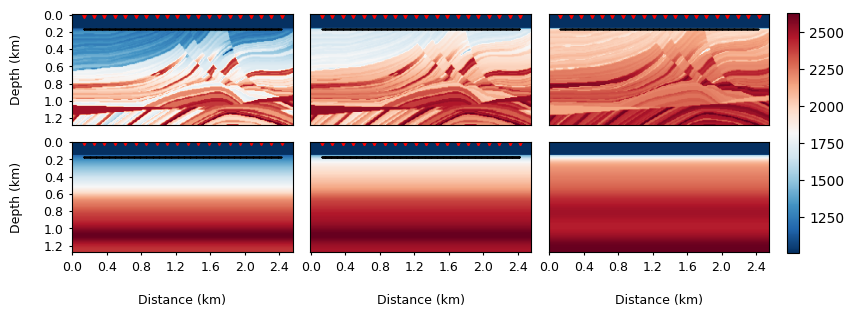

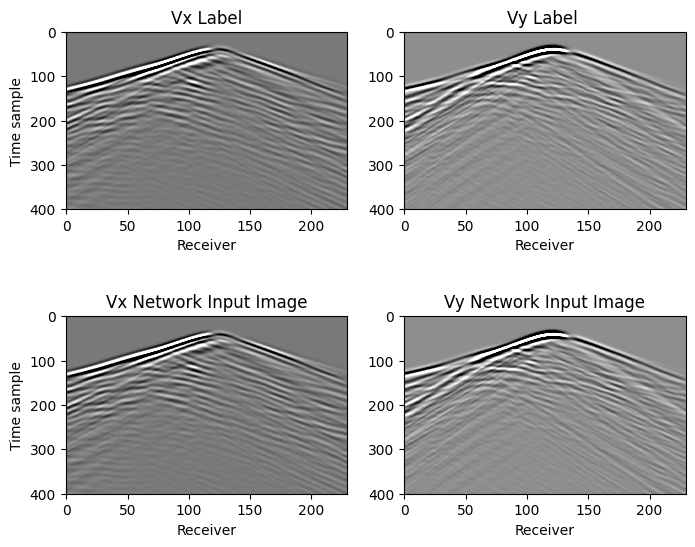

In [8]:
######### load data #########
vp = torch.load(VPPATH).to(DEVICE)
vs =  torch.load(VSPATH).to(DEVICE)
rho =  torch.load(rhoPATH).to(DEVICE)

vp_initial = torch.load(VPinitialPATH).to(DEVICE)
vs_initial = torch.load(VSinitialPATH).to(DEVICE)
rho_initial = torch.load(rhoinitialPATH).to(DEVICE)


d_obs_vx = torch.load(d_obs_vx_PATH).to(DEVICE)
print('aaaa',d_obs_vx.shape)
d_obs_vx = Downsample(d_obs_vx,DEEPWAVE_SIZE,N_RECEIVERS).to(DEVICE)
print(d_obs_vx.shape)

d_obs_vy = torch.load(d_obs_vy_PATH).to(DEVICE)
d_obs_vy = Downsample(d_obs_vy,DEEPWAVE_SIZE,N_RECEIVERS).to(DEVICE)
print(d_obs_vy.shape)

input_vx = torch.load(input_vx_PATH).to(DEVICE)
input_vx = Downsample(input_vx,MODEL_INPUT_SIZE,N_RECEIVERS).to(DEVICE)
print(input_vx.shape)
input_vy = torch.load(input_vy_PATH).to(DEVICE)
input_vy = Downsample(input_vy,MODEL_INPUT_SIZE,N_RECEIVERS).to(DEVICE)
print(input_vy.shape)
#print(d_obs_vx.device)
######### polt data #########
VP_MIN = vp.min().item()
VP_MAX = vp.max().item()
VS_MIN = vs.min().item()
VS_MAX = vs.max().item()

fig, ax = plt.subplots(2, 3, figsize=(9, 12))
fig0 = ax[0,0].imshow(vp.cpu().numpy(), cmap= 'RdBu_r')
ax[0,0].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[0,0].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[0,0].tick_params(axis='x', which='both',labelleft=True , labelbottom=False)
ax[0,0].set_xticks([])
ax[0,0].set_yticks(np.arange(0,128,20),(DH*np.arange(0,128,20))/1000)
ax[0,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[0,0].set_ylabel("Depth (km)\n",fontsize=9)


fig1 = ax[0,1].imshow(vs.cpu().numpy(), cmap= 'RdBu_r')
ax[0,1].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[0,1].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[0,1].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[0,1].set_xticks([])
ax[0,1].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[0,1].set_yticks([])

fig1 = ax[0,2].imshow(rho.cpu().numpy(), cmap= 'RdBu_r')
ax[0,2].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[0,2].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[0,2].tick_params(axis='x', which='both',labelleft=False , labelbottom=False)
ax[0,2].set_xticks([])
ax[0,2].tick_params(axis='y', which='both',labelleft=False , labelbottom=False)
ax[0,2].set_yticks([])


fig2 = ax[1,0].imshow(vp_initial.cpu().numpy(), cmap= 'RdBu_r')
ax[1,0].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[1,0].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[1,0].set_yticks(np.arange(0,128,20),(DH*np.arange(0,128,20))/1000)
ax[1,0].tick_params(axis='y', which='both', length=2.5, labelsize=9)
ax[1,0].set_xticks(np.arange(0,256,40),(DH*np.arange(0,256,40))/1000)
ax[1,0].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[1,0].set_xlabel("\nDistance (km)",fontsize=9)
ax[1,0].set_ylabel("Depth (km)\n",fontsize=9)

fig3 = ax[1,1].imshow(vs_initial.cpu().numpy(), cmap= 'RdBu_r')
ax[1,1].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[1,1].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[1,1].set_yticks([])
ax[1,1].tick_params(axis='x', which='both', labelbottom=True)
ax[1,1].tick_params(axis='y', which='both', labelleft=False)
ax[1,1].set_xticks(np.arange(0,256,40),(DH*np.arange(0,256,40))/1000)
ax[1,1].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[1,1].set_xlabel("\nDistance (km)",fontsize=9)

fig3 = ax[1,2].imshow(rho_initial.cpu().numpy(), cmap= 'RdBu_r')
ax[1,1].plot(rec_loc_temp[:,0]/DH, rec_loc_temp[:, 1]/DH, 'k*', markersize=1)
ax[1,1].plot(src_loc_temp[:,0]/DH, src_loc_temp[:, 1]/DH, 'rv', markersize=4)
ax[1,2].set_yticks([])
ax[1,2].tick_params(axis='x', which='both', labelbottom=True)
ax[1,2].tick_params(axis='y', which='both', labelleft=False)
ax[1,2].set_xticks(np.arange(0,256,40),(DH*np.arange(0,256,40))/1000)
ax[1,2].tick_params(axis='x', which='both', length=2.5, labelsize=9)
ax[1,2].set_xlabel("\nDistance (km)",fontsize=9)

cbar = fig.colorbar(fig1, ax=ax.ravel().tolist())
#cbar.set_label('Label')  
cbar.ax.set_position([0.92,0.395, 3, 0.2]) 
plt.subplots_adjust(hspace=-0.84,wspace=0.08) 
#fig1.set_clim(500, 3000)
#cbar.ax.set_aspect(1)
plt.savefig(Fig_path+f"/velocity_model$initial_model"+".pdf",bbox_inches='tight', dpi=900)
plt.show()

vpmin, vpmax = torch.quantile(d_obs_vx[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]).to(DEVICE))
vsmin, vsmax = torch.quantile(d_obs_vy[N_SHOTS//2],
                                 torch.tensor([0.01, 0.99]).to(DEVICE))

fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax[0,0].imshow(d_obs_vx[N_SHOTS//2].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vpmin, vmax=vpmax)
ax[0,0].set_xlabel("Receiver")
ax[0,0].set_ylabel("Time sample")
ax[0,1].imshow(d_obs_vy[N_SHOTS//2].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vsmin, vmax=vsmax)
ax[0,1].set_xlabel("Receiver")
ax[1,0].imshow(input_vx[N_SHOTS//2].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vpmin, vmax=vpmax)
ax[1,0].set_xlabel("Receiver")
ax[1,0].set_ylabel("Time sample")
ax[1,1].imshow(input_vy[N_SHOTS//2].cpu().detach().numpy(), aspect='auto', cmap='gray',vmin=vsmin, vmax=vsmax)
ax[1,1].set_xlabel("Receiver")
ax[0,0].set_title("Vx Label")
ax[0,1].set_title("Vy Label ")
ax[1,0].set_title("Vx Network Input Image")
ax[1,1].set_title("Vy Network Input Image")
# ax[1].set_ylabel("Time sample")
plt.subplots_adjust(hspace=0.6) 
plt.savefig(Fig_path+f"/obs&input_gather"+".jpg", dpi=900)  
plt.show()

d_obs_vx = d_obs_vx.unsqueeze(0)
d_obs_vy = d_obs_vy.unsqueeze(0)
input_vx = input_vx.unsqueeze(0)
input_vy = input_vy.unsqueeze(0)

In [9]:
criteria = torch.nn.L1Loss(reduction='sum')

transfomerdecoder = Transfomerdecoder(
        batch_size = BATCH_SIZE,
        in_channels = N_SHOTS,
        nt = MODEL_INPUT_SIZE, nr = N_RECEIVERS,
        patch_size = PATCH_SIZE,
        embed_dim = EMBED_DIM,
        transddepth = TRANSDDEPTH,
        n_blocks_decoder = N_BLOCKS_DECODER,
        final_size_encoder = FINAL_SIZE_ENCODER,
        initial_shape_decoder = DECODER_INITIAL_SHAPE,
        final_spatial_shape = model_shape,
        num_heads = NUM_HEADS,
        mlp_ratio = MPL_RATION
        ).to(DEVICE)

In [10]:
optim_transfomerdecoder = torch.optim.Adam(transfomerdecoder.parameters(), lr=learn, betas=(0.5, 0.9))
scheduler_transfomerdecoder = torch.optim.lr_scheduler.StepLR(optim_transfomerdecoder, LR_MILESTONE, gamma=0.5)
all_loss_data = []
all_loss_vx_model = []
all_loss_vy_model = []
all_loss_rho_model = []
all_loss_model =[]

Iteration 1 ===== loss: 0.0024160456960089505 for data and 16873308.0 for model
Iteration 2 ===== loss: 0.002410950430203229 for data and 16867958.75 for model
Iteration 3 ===== loss: 0.0024051304790191352 for data and 16862901.5 for model
Iteration 4 ===== loss: 0.002398460521362722 for data and 16859460.0 for model
Iteration 5 ===== loss: 0.0023917321232147515 for data and 16856795.0 for model
Iteration 6 ===== loss: 0.0023841086658649147 for data and 16854893.0 for model
Iteration 7 ===== loss: 0.002378755249083042 for data and 16856684.5 for model
Iteration 8 ===== loss: 0.0023724501952528954 for data and 16848283.75 for model
Iteration 9 ===== loss: 0.002366292814258486 for data and 16846174.0 for model
Iteration 10 ===== loss: 0.002360804646741599 for data and 16841755.75 for model
Iteration 11 ===== loss: 0.0023569416953250766 for data and 16839668.0 for model
Iteration 12 ===== loss: 0.0023507362930104136 for data and 16835084.25 for model
Iteration 13 ===== loss: 0.00234618037

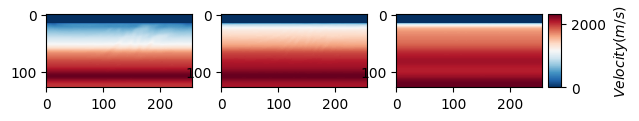

Iteration 51 ===== loss: 0.0021848954493179917 for data and 16767855.0 for model
Iteration 52 ===== loss: 0.0021818203385919333 for data and 16767606.5 for model
Iteration 53 ===== loss: 0.0021782207768410444 for data and 16766416.5 for model
Iteration 54 ===== loss: 0.0021747819846495986 for data and 16759625.5 for model
Iteration 55 ===== loss: 0.002171627711504698 for data and 16759173.5 for model
Iteration 56 ===== loss: 0.0021682080696336925 for data and 16752353.75 for model
Iteration 57 ===== loss: 0.002165068406611681 for data and 16748462.0 for model
Iteration 58 ===== loss: 0.0021620350889861584 for data and 16746425.5 for model
Iteration 59 ===== loss: 0.002158982155378908 for data and 16742609.5 for model
Iteration 60 ===== loss: 0.002156004949938506 for data and 16734392.0 for model
Iteration 61 ===== loss: 0.0021529513760469854 for data and 16737009.5 for model
Iteration 62 ===== loss: 0.002150073938537389 for data and 16737046.5 for model
Iteration 63 ===== loss: 0.00214

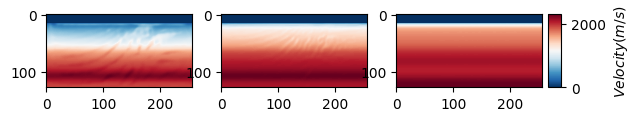

Iteration 101 ===== loss: 0.002042027685092762 for data and 16627069.25 for model
Iteration 102 ===== loss: 0.002039344428339973 for data and 16607709.5 for model
Iteration 103 ===== loss: 0.002036557998508215 for data and 16618714.75 for model
Iteration 104 ===== loss: 0.0020336617599241436 for data and 16599359.0 for model
Iteration 105 ===== loss: 0.0020304881036281586 for data and 16600717.5 for model
Iteration 106 ===== loss: 0.002027100359555334 for data and 16627111.0 for model
Iteration 107 ===== loss: 0.002023767534410581 for data and 16621455.5 for model
Iteration 108 ===== loss: 0.00202047560014762 for data and 16610155.25 for model
Iteration 109 ===== loss: 0.002018385916016996 for data and 16604078.25 for model
Iteration 110 ===== loss: 0.002015514764934778 for data and 16620700.5 for model
Iteration 111 ===== loss: 0.0020132582576479763 for data and 16613443.0 for model
Iteration 112 ===== loss: 0.0020105193252675235 for data and 16617726.0 for model
Iteration 113 ===== l

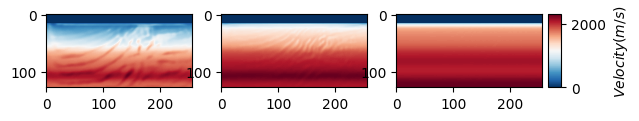

Iteration 151 ===== loss: 0.001846878876676783 for data and 16391872.0 for model
Iteration 152 ===== loss: 0.0018445835739839822 for data and 16400312.0 for model
Iteration 153 ===== loss: 0.0018391808844171464 for data and 16402705.25 for model
Iteration 154 ===== loss: 0.0018314819899387658 for data and 16371611.5 for model
Iteration 155 ===== loss: 0.001823755941586569 for data and 16381022.0 for model
Iteration 156 ===== loss: 0.0018172120326198637 for data and 16369484.75 for model
Iteration 157 ===== loss: 0.0018208900874014944 for data and 16339331.75 for model
Iteration 158 ===== loss: 0.0018074496474582702 for data and 16388066.0 for model
Iteration 159 ===== loss: 0.0018024711171165109 for data and 16324838.5 for model
Iteration 160 ===== loss: 0.0017954079085029662 for data and 16342522.0 for model
Iteration 161 ===== loss: 0.0017899093218147755 for data and 16344334.0 for model
Iteration 162 ===== loss: 0.0017849001742433757 for data and 16342155.5 for model
Iteration 163 =

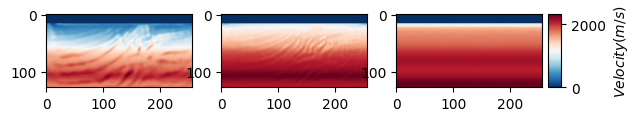

Iteration 201 ===== loss: 0.0015345281863119453 for data and 16099657.5 for model
Iteration 202 ===== loss: 0.0015545903879683465 for data and 16069439.0 for model
Iteration 203 ===== loss: 0.00153338277596049 for data and 16087666.0 for model
Iteration 204 ===== loss: 0.001514328265329823 for data and 16088901.0 for model
Iteration 205 ===== loss: 0.0015073273971211165 for data and 16077048.5 for model
Iteration 206 ===== loss: 0.0015203010407276452 for data and 16057581.0 for model
Iteration 207 ===== loss: 0.0015073587710503489 for data and 16036106.0 for model
Iteration 208 ===== loss: 0.0014934151549823582 for data and 16072934.25 for model
Iteration 209 ===== loss: 0.0014814581081736833 for data and 16020769.5 for model
Iteration 210 ===== loss: 0.0014809591230005026 for data and 16039813.0 for model
Iteration 211 ===== loss: 0.0015134217392187566 for data and 16033052.0 for model
Iteration 212 ===== loss: 0.001472493604524061 for data and 16023474.25 for model
Iteration 213 ====

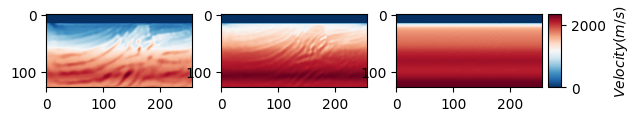

Iteration 251 ===== loss: 0.0012934196856804192 for data and 15794946.0 for model
Iteration 252 ===== loss: 0.0012462007871363312 for data and 15775846.0 for model
Iteration 253 ===== loss: 0.0012581213668454438 for data and 15739572.5 for model
Iteration 254 ===== loss: 0.0012337712105363607 for data and 15736417.75 for model
Iteration 255 ===== loss: 0.0012509297812357545 for data and 15767293.5 for model
Iteration 256 ===== loss: 0.0012506201746873558 for data and 15697864.75 for model
Iteration 257 ===== loss: 0.001237321994267404 for data and 15726494.75 for model
Iteration 258 ===== loss: 0.001225427200552076 for data and 15721864.5 for model
Iteration 259 ===== loss: 0.0012117565493099391 for data and 15724389.0 for model
Iteration 260 ===== loss: 0.0012201480858493596 for data and 15733818.0 for model
Iteration 261 ===== loss: 0.0012066049966961145 for data and 15709016.0 for model
Iteration 262 ===== loss: 0.001188246620586142 for data and 15705937.0 for model
Iteration 263 ==

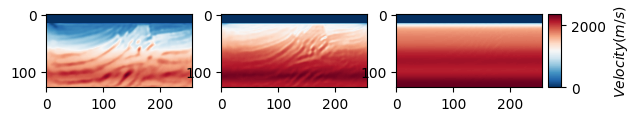

Iteration 301 ===== loss: 0.0010686260065995157 for data and 15501993.0 for model
Iteration 302 ===== loss: 0.001070099329808727 for data and 15460850.0 for model
Iteration 303 ===== loss: 0.0010740622237790376 for data and 15487999.0 for model
Iteration 304 ===== loss: 0.001035206252709031 for data and 15462010.25 for model
Iteration 305 ===== loss: 0.0010579500230960548 for data and 15437998.5 for model
Iteration 306 ===== loss: 0.0010567788558546454 for data and 15490988.0 for model
Iteration 307 ===== loss: 0.0010674185323296115 for data and 15452430.5 for model
Iteration 308 ===== loss: 0.00102724798489362 for data and 15430131.5 for model
Iteration 309 ===== loss: 0.0010547097190283239 for data and 15454001.0 for model
Iteration 310 ===== loss: 0.0010220635449513793 for data and 15442383.5 for model
Iteration 311 ===== loss: 0.00104201165959239 for data and 15431467.25 for model
Iteration 312 ===== loss: 0.0010236373636871576 for data and 15449159.5 for model
Iteration 313 ===== 

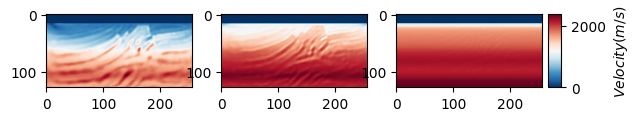

Iteration 351 ===== loss: 0.0009730082674650475 for data and 15230393.5 for model
Iteration 352 ===== loss: 0.0009243711974704638 for data and 15190399.0 for model
Iteration 353 ===== loss: 0.0009607270039850846 for data and 15250262.5 for model
Iteration 354 ===== loss: 0.000918190780794248 for data and 15225379.5 for model
Iteration 355 ===== loss: 0.0009174497245112434 for data and 15172308.0 for model
Iteration 356 ===== loss: 0.000974602866335772 for data and 15222132.25 for model
Iteration 357 ===== loss: 0.0009152938146144152 for data and 15193615.5 for model
Iteration 358 ===== loss: 0.0009105031203944236 for data and 15161633.5 for model
Iteration 359 ===== loss: 0.0009570963884470984 for data and 15209626.5 for model
Iteration 360 ===== loss: 0.0009685360855655745 for data and 15159330.0 for model
Iteration 361 ===== loss: 0.0009073849068954587 for data and 15195813.25 for model
Iteration 362 ===== loss: 0.0009363479621242732 for data and 15177358.75 for model
Iteration 363 =

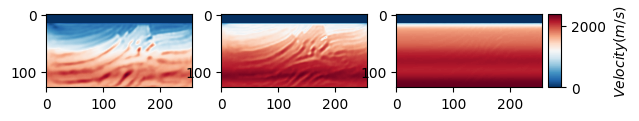

Iteration 401 ===== loss: 0.0008561402355553582 for data and 14982949.5 for model
Iteration 402 ===== loss: 0.0008788909617578611 for data and 15029897.5 for model
Iteration 403 ===== loss: 0.0008390329021494836 for data and 14976190.5 for model
Iteration 404 ===== loss: 0.0008624463516753167 for data and 14983209.5 for model
Iteration 405 ===== loss: 0.000841677887365222 for data and 14970083.5 for model
Iteration 406 ===== loss: 0.0008703650819370523 for data and 14991036.5 for model
Iteration 407 ===== loss: 0.0008658165752422065 for data and 14962429.0 for model
Iteration 408 ===== loss: 0.0008588550554122776 for data and 14952737.25 for model
Iteration 409 ===== loss: 0.0008519285183865577 for data and 14963635.5 for model
Iteration 410 ===== loss: 0.0008430900197708979 for data and 14980286.25 for model
Iteration 411 ===== loss: 0.000856370766996406 for data and 14916885.75 for model
Iteration 412 ===== loss: 0.0008395047480007634 for data and 14956495.75 for model
Iteration 413 

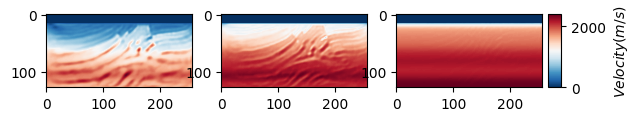

Iteration 451 ===== loss: 0.0008354807505384088 for data and 14772157.5 for model
Iteration 452 ===== loss: 0.0008037909574341029 for data and 14794905.0 for model
Iteration 453 ===== loss: 0.0008005913550732657 for data and 14767150.5 for model
Iteration 454 ===== loss: 0.0007763281901134178 for data and 14776609.5 for model
Iteration 455 ===== loss: 0.0007966631092131138 for data and 14744269.5 for model
Iteration 456 ===== loss: 0.0007993589679244906 for data and 14794092.75 for model
Iteration 457 ===== loss: 0.0007599507662234828 for data and 14748170.0 for model
Iteration 458 ===== loss: 0.0008205636258935556 for data and 14774483.0 for model
Iteration 459 ===== loss: 0.0007633478671777993 for data and 14746976.25 for model
Iteration 460 ===== loss: 0.0008061095140874386 for data and 14749128.0 for model
Iteration 461 ===== loss: 0.0007686821481911466 for data and 14764427.5 for model
Iteration 462 ===== loss: 0.0007772504031891003 for data and 14713731.0 for model
Iteration 463 

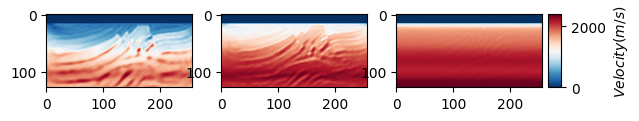

Iteration 501 ===== loss: 0.0007930529536679387 for data and 14632125.5 for model
Iteration 502 ===== loss: 0.000723963908967562 for data and 14593732.0 for model
Iteration 503 ===== loss: 0.0007629087194800377 for data and 14616023.0 for model
Iteration 504 ===== loss: 0.0007226788584375754 for data and 14585387.0 for model
Iteration 505 ===== loss: 0.0007124428957467899 for data and 14584451.5 for model
Iteration 506 ===== loss: 0.0007649212202522904 for data and 14598161.0 for model
Iteration 507 ===== loss: 0.0007318552670767531 for data and 14605671.0 for model
Iteration 508 ===== loss: 0.0007677064568269998 for data and 14599027.5 for model
Iteration 509 ===== loss: 0.0007253007643157616 for data and 14607429.0 for model
Iteration 510 ===== loss: 0.0007312972593354061 for data and 14573677.5 for model
Iteration 511 ===== loss: 0.0007333234680118039 for data and 14598584.0 for model
Iteration 512 ===== loss: 0.000722561395377852 for data and 14579700.5 for model
Iteration 513 ====

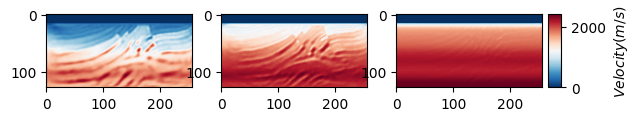

Iteration 551 ===== loss: 0.000699548123520799 for data and 14469231.5 for model
Iteration 552 ===== loss: 0.0006875923281768337 for data and 14435508.75 for model
Iteration 553 ===== loss: 0.0006936753779882565 for data and 14461021.0 for model
Iteration 554 ===== loss: 0.0006977083103265613 for data and 14460529.0 for model
Iteration 555 ===== loss: 0.0007340380398090929 for data and 14432482.0 for model
Iteration 556 ===== loss: 0.0007173900085035712 for data and 14423158.0 for model
Iteration 557 ===== loss: 0.0006714537303196266 for data and 14430707.75 for model
Iteration 558 ===== loss: 0.0007172721670940518 for data and 14444963.5 for model
Iteration 559 ===== loss: 0.0006824860611231998 for data and 14424173.0 for model
Iteration 560 ===== loss: 0.000674787923344411 for data and 14408315.0 for model
Iteration 561 ===== loss: 0.0007060428033582866 for data and 14431277.5 for model
Iteration 562 ===== loss: 0.0006743151898263022 for data and 14398259.75 for model
Iteration 563 =

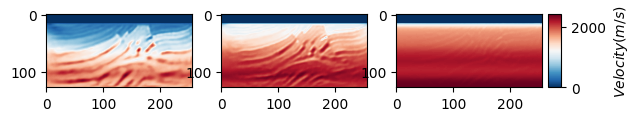

Iteration 601 ===== loss: 0.0006485767808044329 for data and 14340441.5 for model
Iteration 602 ===== loss: 0.0006751081673428416 for data and 14294664.25 for model
Iteration 603 ===== loss: 0.0006563029164681211 for data and 14301298.0 for model
Iteration 604 ===== loss: 0.0006757320079486817 for data and 14310623.5 for model
Iteration 605 ===== loss: 0.0006701466190861538 for data and 14311640.75 for model
Iteration 606 ===== loss: 0.0006475891277659684 for data and 14267000.75 for model
Iteration 607 ===== loss: 0.0006750060711055994 for data and 14302937.0 for model
Iteration 608 ===== loss: 0.0006423243321478367 for data and 14285484.75 for model
Iteration 609 ===== loss: 0.0006266848940867931 for data and 14264336.75 for model
Iteration 610 ===== loss: 0.0006903440662426874 for data and 14290225.0 for model
Iteration 611 ===== loss: 0.0006425558967748657 for data and 14285292.0 for model
Iteration 612 ===== loss: 0.0006909522053319961 for data and 14271437.75 for model
Iteration 

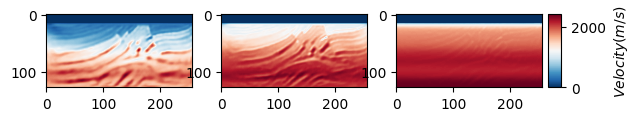

Iteration 651 ===== loss: 0.0006147963867988437 for data and 14189568.25 for model
Iteration 652 ===== loss: 0.0006377070385497063 for data and 14164958.75 for model
Iteration 653 ===== loss: 0.0006315461796475574 for data and 14190622.75 for model
Iteration 654 ===== loss: 0.0006377434328896925 for data and 14171990.0 for model
Iteration 655 ===== loss: 0.0006318085215752944 for data and 14147055.5 for model
Iteration 656 ===== loss: 0.0006495272245956585 for data and 14167961.0 for model
Iteration 657 ===== loss: 0.0006085288332542405 for data and 14159127.75 for model
Iteration 658 ===== loss: 0.0006229811551747844 for data and 14148252.25 for model
Iteration 659 ===== loss: 0.0006233103922568262 for data and 14163868.25 for model
Iteration 660 ===== loss: 0.000652803122648038 for data and 14164170.5 for model
Iteration 661 ===== loss: 0.00062621729739476 for data and 14158553.75 for model
Iteration 662 ===== loss: 0.0006074754928704351 for data and 14161546.5 for model
Iteration 66

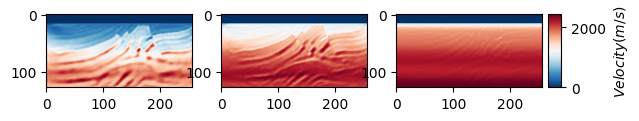

Iteration 701 ===== loss: 0.0006084970227675512 for data and 14073964.25 for model
Iteration 702 ===== loss: 0.0006020367000019178 for data and 14056967.0 for model
Iteration 703 ===== loss: 0.0006108631932875142 for data and 14061434.0 for model
Iteration 704 ===== loss: 0.0005687440425390378 for data and 14045677.75 for model
Iteration 705 ===== loss: 0.0006591736164409667 for data and 14060112.0 for model
Iteration 706 ===== loss: 0.000584307694225572 for data and 14049935.0 for model
Iteration 707 ===== loss: 0.0005762395448982716 for data and 14053491.75 for model
Iteration 708 ===== loss: 0.0006398545083357021 for data and 14046342.0 for model
Iteration 709 ===== loss: 0.0005799798527732491 for data and 14043050.0 for model
Iteration 710 ===== loss: 0.000608325470238924 for data and 14054744.25 for model
Iteration 711 ===== loss: 0.0006006346084177494 for data and 14020273.75 for model
Iteration 712 ===== loss: 0.000591001269640401 for data and 14043406.75 for model
Iteration 713

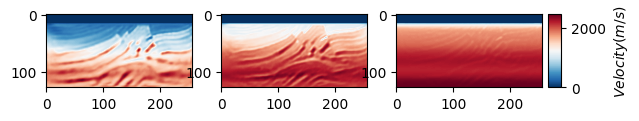

Iteration 751 ===== loss: 0.0005562468140851706 for data and 13936930.75 for model
Iteration 752 ===== loss: 0.0006042172462912276 for data and 13908744.0 for model
Iteration 753 ===== loss: 0.0006020345608703792 for data and 13933247.25 for model
Iteration 754 ===== loss: 0.00056583306286484 for data and 13934455.0 for model
Iteration 755 ===== loss: 0.0005982056027278304 for data and 13925733.5 for model
Iteration 756 ===== loss: 0.0005613450339296833 for data and 13900196.75 for model
Iteration 757 ===== loss: 0.0005725828086724505 for data and 13932821.75 for model
Iteration 758 ===== loss: 0.0005688548844773322 for data and 13900960.75 for model
Iteration 759 ===== loss: 0.0005935149674769491 for data and 13934095.5 for model
Iteration 760 ===== loss: 0.0005747777177020907 for data and 13931821.5 for model
Iteration 761 ===== loss: 0.000556152401259169 for data and 13910145.25 for model
Iteration 762 ===== loss: 0.0006033279205439612 for data and 13883629.25 for model
Iteration 76

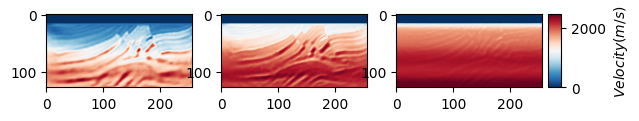

Iteration 801 ===== loss: 0.0005434885097201914 for data and 13817366.25 for model
Iteration 802 ===== loss: 0.0005562443839153275 for data and 13831171.5 for model
Iteration 803 ===== loss: 0.0006113291456131265 for data and 13794768.75 for model
Iteration 804 ===== loss: 0.0005946411256445572 for data and 13828272.0 for model
Iteration 805 ===== loss: 0.0005259213357931003 for data and 13833323.0 for model
Iteration 806 ===== loss: 0.0005825201515108347 for data and 13850985.25 for model
Iteration 807 ===== loss: 0.0005320141208358109 for data and 13807538.0 for model
Iteration 808 ===== loss: 0.0005318335897754878 for data and 13814124.0 for model
Iteration 809 ===== loss: 0.0005692341946996748 for data and 13822906.0 for model
Iteration 810 ===== loss: 0.0005296414892654866 for data and 13798124.5 for model
Iteration 811 ===== loss: 0.0005248825764283538 for data and 13814079.0 for model
Iteration 812 ===== loss: 0.0005975081730866805 for data and 13792085.5 for model
Iteration 813

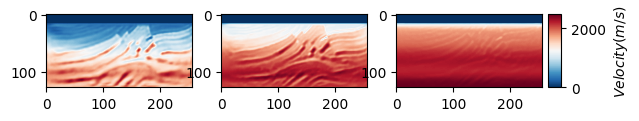

Iteration 851 ===== loss: 0.0005217099824221805 for data and 13718976.0 for model
Iteration 852 ===== loss: 0.0005333270528353751 for data and 13710838.75 for model
Iteration 853 ===== loss: 0.0005288411921355873 for data and 13688838.25 for model
Iteration 854 ===== loss: 0.0005690191173925996 for data and 13714563.5 for model
Iteration 855 ===== loss: 0.0005112180078867823 for data and 13675711.0 for model
Iteration 856 ===== loss: 0.0005460828542709351 for data and 13678060.5 for model
Iteration 857 ===== loss: 0.0005138580891070887 for data and 13681878.0 for model
Iteration 858 ===== loss: 0.0005571797082666308 for data and 13706674.0 for model
Iteration 859 ===== loss: 0.000521835929248482 for data and 13705062.0 for model
Iteration 860 ===== loss: 0.0005334068118827417 for data and 13703932.25 for model
Iteration 861 ===== loss: 0.0005466055299621075 for data and 13674071.75 for model
Iteration 862 ===== loss: 0.000545498653082177 for data and 13681163.0 for model
Iteration 863 

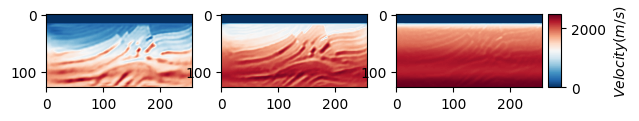

Iteration 901 ===== loss: 0.0005018522497266531 for data and 13598920.25 for model
Iteration 902 ===== loss: 0.000513457547640428 for data and 13603374.25 for model
Iteration 903 ===== loss: 0.0005001148238079622 for data and 13582917.5 for model
Iteration 904 ===== loss: 0.000551329052541405 for data and 13556286.5 for model
Iteration 905 ===== loss: 0.000498186083859764 for data and 13580360.25 for model
Iteration 906 ===== loss: 0.0005154427199158818 for data and 13563782.0 for model
Iteration 907 ===== loss: 0.0005207434296607971 for data and 13586358.0 for model
Iteration 908 ===== loss: 0.0005040159885538742 for data and 13576432.5 for model
Iteration 909 ===== loss: 0.0005317643226590008 for data and 13552649.5 for model
Iteration 910 ===== loss: 0.0005263562052277848 for data and 13560076.0 for model
Iteration 911 ===== loss: 0.0004998987569706514 for data and 13569447.0 for model
Iteration 912 ===== loss: 0.0005340179486665875 for data and 13593276.25 for model
Iteration 913 =

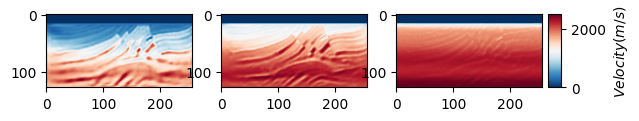

Iteration 951 ===== loss: 0.0004994911651010625 for data and 13503244.5 for model
Iteration 952 ===== loss: 0.00048665032954886556 for data and 13485524.75 for model
Iteration 953 ===== loss: 0.0005368542770156637 for data and 13455160.0 for model
Iteration 954 ===== loss: 0.0004850216573686339 for data and 13486728.5 for model
Iteration 955 ===== loss: 0.0004959612633683719 for data and 13463135.5 for model
Iteration 956 ===== loss: 0.0004977488133590668 for data and 13449629.75 for model
Iteration 957 ===== loss: 0.0004906290705548599 for data and 13478732.25 for model
Iteration 958 ===== loss: 0.0004934205717290752 for data and 13460669.25 for model
Iteration 959 ===== loss: 0.0005020503449486569 for data and 13471021.5 for model
Iteration 960 ===== loss: 0.0005218325677560642 for data and 13468281.5 for model
Iteration 961 ===== loss: 0.000477359993965365 for data and 13457501.25 for model
Iteration 962 ===== loss: 0.00048590901133138686 for data and 13446922.0 for model
Iteration 

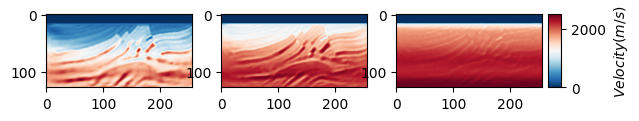

Iteration 1001 ===== loss: 0.0004598726736730896 for data and 13349267.0 for model
Iteration 1002 ===== loss: 0.000519395041919779 for data and 13351517.5 for model
Iteration 1003 ===== loss: 0.00045658485032618046 for data and 13356186.25 for model
Iteration 1004 ===== loss: 0.0004802839830517769 for data and 13345712.5 for model
Iteration 1005 ===== loss: 0.0004931751536787488 for data and 13341597.0 for model
Iteration 1006 ===== loss: 0.00045875571959186345 for data and 13353649.5 for model
Iteration 1007 ===== loss: 0.0005181374726817012 for data and 13337797.25 for model
Iteration 1008 ===== loss: 0.000470626175228972 for data and 13340691.0 for model
Iteration 1009 ===== loss: 0.00048574772517895326 for data and 13351649.0 for model
Iteration 1010 ===== loss: 0.00045812734606442973 for data and 13327501.25 for model
Iteration 1011 ===== loss: 0.0005027120496379212 for data and 13335166.5 for model
Iteration 1012 ===== loss: 0.0004829084864468314 for data and 13340879.75 for mode

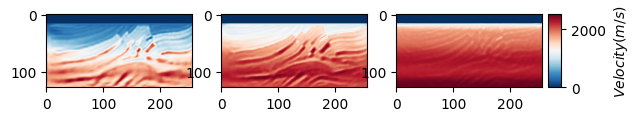

Iteration 1051 ===== loss: 0.000438079223386012 for data and 13230078.5 for model
Iteration 1052 ===== loss: 0.0004761793024954386 for data and 13240498.0 for model
Iteration 1053 ===== loss: 0.0004487299738684669 for data and 13223209.0 for model
Iteration 1054 ===== loss: 0.00048287842218996957 for data and 13238039.5 for model
Iteration 1055 ===== loss: 0.00047922878729877993 for data and 13213233.0 for model
Iteration 1056 ===== loss: 0.0004538320063147694 for data and 13209895.0 for model
Iteration 1057 ===== loss: 0.00048303867515642196 for data and 13198994.0 for model
Iteration 1058 ===== loss: 0.00044606356095755473 for data and 13230956.5 for model
Iteration 1059 ===== loss: 0.0005008935841033235 for data and 13211886.0 for model
Iteration 1060 ===== loss: 0.0004574225968099199 for data and 13213491.25 for model
Iteration 1061 ===== loss: 0.0004737234194180928 for data and 13223916.0 for model
Iteration 1062 ===== loss: 0.0004592549448716454 for data and 13199718.0 for model


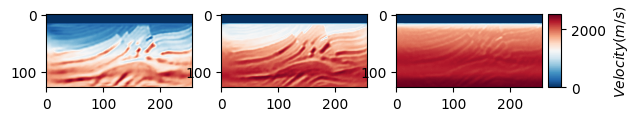

Iteration 1101 ===== loss: 0.0004585722563206218 for data and 13134990.0 for model
Iteration 1102 ===== loss: 0.0004443026482476853 for data and 13117847.5 for model
Iteration 1103 ===== loss: 0.00044806761434301734 for data and 13106447.5 for model
Iteration 1104 ===== loss: 0.0004379462407086976 for data and 13091300.5 for model
Iteration 1105 ===== loss: 0.0005023441335652024 for data and 13094166.5 for model
Iteration 1106 ===== loss: 0.0004423966383910738 for data and 13118212.25 for model
Iteration 1107 ===== loss: 0.00043812049261759967 for data and 13116190.25 for model
Iteration 1108 ===== loss: 0.00047123405965976417 for data and 13086641.25 for model
Iteration 1109 ===== loss: 0.00045135885739000514 for data and 13089855.5 for model
Iteration 1110 ===== loss: 0.00044958001672057435 for data and 13113473.5 for model
Iteration 1111 ===== loss: 0.0004327985952841118 for data and 13085403.25 for model
Iteration 1112 ===== loss: 0.000458874405012466 for data and 13109336.5 for mo

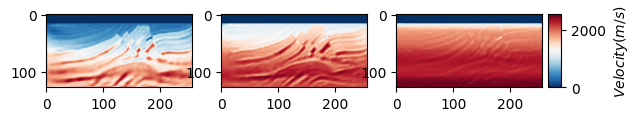

Iteration 1151 ===== loss: 0.0004194636640022509 for data and 13009343.0 for model
Iteration 1152 ===== loss: 0.0004440276898094453 for data and 13007502.0 for model
Iteration 1153 ===== loss: 0.0004301744484109804 for data and 12999375.0 for model
Iteration 1154 ===== loss: 0.00045897239760961384 for data and 12986677.25 for model
Iteration 1155 ===== loss: 0.00042973772360710427 for data and 12979326.5 for model
Iteration 1156 ===== loss: 0.00043233447649981827 for data and 12985253.25 for model
Iteration 1157 ===== loss: 0.00043182179797440767 for data and 12991776.5 for model
Iteration 1158 ===== loss: 0.00045823328400729224 for data and 12989471.5 for model
Iteration 1159 ===== loss: 0.00042210976243950427 for data and 12982154.25 for model
Iteration 1160 ===== loss: 0.000465851160697639 for data and 12998763.0 for model
Iteration 1161 ===== loss: 0.00042178954754490405 for data and 12979478.25 for model
Iteration 1162 ===== loss: 0.00044166141015011817 for data and 12993648.0 for

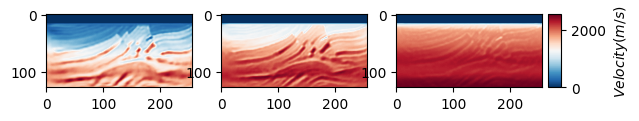

Iteration 1201 ===== loss: 0.00044136217911727726 for data and 12901790.5 for model
Iteration 1202 ===== loss: 0.00041820815386017784 for data and 12897637.5 for model
Iteration 1203 ===== loss: 0.0004230318154441193 for data and 12891459.75 for model
Iteration 1204 ===== loss: 0.0004290165234124288 for data and 12906000.0 for model
Iteration 1205 ===== loss: 0.00043360832933103666 for data and 12888150.25 for model
Iteration 1206 ===== loss: 0.00044714577961713076 for data and 12893494.0 for model
Iteration 1207 ===== loss: 0.00042974088137270883 for data and 12892200.5 for model
Iteration 1208 ===== loss: 0.00042254477739334106 for data and 12853007.0 for model
Iteration 1209 ===== loss: 0.000440805459220428 for data and 12864402.0 for model
Iteration 1210 ===== loss: 0.0004019096595584415 for data and 12870640.25 for model
Iteration 1211 ===== loss: 0.00042882316483883187 for data and 12862314.0 for model
Iteration 1212 ===== loss: 0.00043207284761592746 for data and 12844242.0 for 

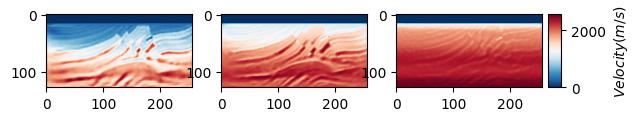

Iteration 1251 ===== loss: 0.00043194679165026173 for data and 12797093.5 for model
Iteration 1252 ===== loss: 0.0003966635122196749 for data and 12778329.75 for model
Iteration 1253 ===== loss: 0.00041046658589039 for data and 12798257.0 for model
Iteration 1254 ===== loss: 0.0004096541670151055 for data and 12761536.25 for model
Iteration 1255 ===== loss: 0.00039762582309776917 for data and 12761859.75 for model
Iteration 1256 ===== loss: 0.000451010579126887 for data and 12766888.25 for model
Iteration 1257 ===== loss: 0.0004054266682942398 for data and 12752429.0 for model
Iteration 1258 ===== loss: 0.000423440826125443 for data and 12770878.25 for model
Iteration 1259 ===== loss: 0.0004009603217127733 for data and 12763278.5 for model
Iteration 1260 ===== loss: 0.00040186187106883153 for data and 12757017.5 for model
Iteration 1261 ===== loss: 0.0004149778324062936 for data and 12772112.75 for model
Iteration 1262 ===== loss: 0.0004005734735983424 for data and 12744913.0 for model

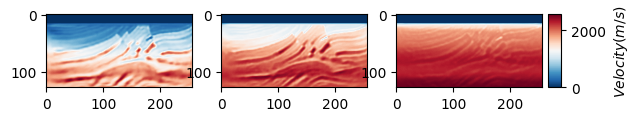

Iteration 1301 ===== loss: 0.0004123549006180838 for data and 12695339.5 for model
Iteration 1302 ===== loss: 0.0003940562964999117 for data and 12684999.0 for model
Iteration 1303 ===== loss: 0.0004009117910754867 for data and 12678806.25 for model
Iteration 1304 ===== loss: 0.0004222032366669737 for data and 12645112.5 for model
Iteration 1305 ===== loss: 0.0004146651262999512 for data and 12683868.25 for model
Iteration 1306 ===== loss: 0.0003874223111779429 for data and 12660783.25 for model
Iteration 1307 ===== loss: 0.00041432742727920413 for data and 12651707.75 for model
Iteration 1308 ===== loss: 0.00040469338273396716 for data and 12648262.75 for model
Iteration 1309 ===== loss: 0.00039889007894089445 for data and 12660306.0 for model
Iteration 1310 ===== loss: 0.00039123411261243746 for data and 12643789.75 for model
Iteration 1311 ===== loss: 0.0004147863946855068 for data and 12661374.25 for model
Iteration 1312 ===== loss: 0.0004008333489764482 for data and 12665512.25 fo

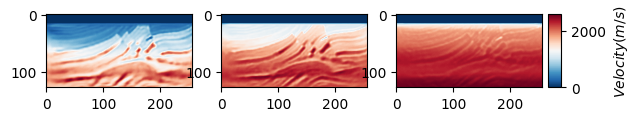

Iteration 1351 ===== loss: 0.0004178296003374271 for data and 12572623.25 for model
Iteration 1352 ===== loss: 0.00037198411882855 for data and 12547498.25 for model
Iteration 1353 ===== loss: 0.00039564593316754326 for data and 12575439.5 for model
Iteration 1354 ===== loss: 0.00037776268436573446 for data and 12554125.75 for model
Iteration 1355 ===== loss: 0.00037785538734169677 for data and 12544859.0 for model
Iteration 1356 ===== loss: 0.0004535927146207541 for data and 12546183.75 for model
Iteration 1357 ===== loss: 0.0003868149942718446 for data and 12562806.25 for model
Iteration 1358 ===== loss: 0.00039302669028984383 for data and 12555722.75 for model
Iteration 1359 ===== loss: 0.0003935997956432402 for data and 12538898.75 for model
Iteration 1360 ===== loss: 0.0003994981379946694 for data and 12565550.5 for model
Iteration 1361 ===== loss: 0.0003718614607350901 for data and 12559219.0 for model
Iteration 1362 ===== loss: 0.0003833189475699328 for data and 12561795.25 for 

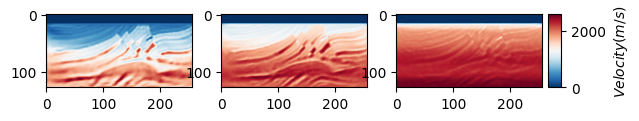

Iteration 1401 ===== loss: 0.00040174165769713 for data and 12465021.75 for model
Iteration 1402 ===== loss: 0.0003686059426399879 for data and 12463464.25 for model
Iteration 1403 ===== loss: 0.0003948386001866311 for data and 12476817.5 for model
Iteration 1404 ===== loss: 0.0003830527202808298 for data and 12451157.25 for model
Iteration 1405 ===== loss: 0.0003763044805964455 for data and 12441139.0 for model
Iteration 1406 ===== loss: 0.0003812239665421657 for data and 12458613.75 for model
Iteration 1407 ===== loss: 0.00038550668250536546 for data and 12462406.75 for model
Iteration 1408 ===== loss: 0.0003825914827757515 for data and 12439085.0 for model
Iteration 1409 ===== loss: 0.0003758160164579749 for data and 12439537.75 for model
Iteration 1410 ===== loss: 0.00039116336120059714 for data and 12460559.0 for model
Iteration 1411 ===== loss: 0.00036711834400193766 for data and 12447253.5 for model
Iteration 1412 ===== loss: 0.00037796059041284025 for data and 12439316.75 for m

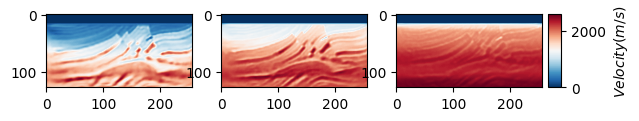

Iteration 1451 ===== loss: 0.00037187539419392124 for data and 12342813.5 for model
Iteration 1452 ===== loss: 0.00037645245174644515 for data and 12365541.5 for model
Iteration 1453 ===== loss: 0.0003497576908557676 for data and 12360037.0 for model
Iteration 1454 ===== loss: 0.000384059501811862 for data and 12351243.5 for model
Iteration 1455 ===== loss: 0.0003775712539209053 for data and 12344224.5 for model
Iteration 1456 ===== loss: 0.00038197314279386774 for data and 12363443.0 for model
Iteration 1457 ===== loss: 0.00035087595460936427 for data and 12359937.5 for model
Iteration 1458 ===== loss: 0.00034927955857710913 for data and 12365447.25 for model
Iteration 1459 ===== loss: 0.00040666500717634335 for data and 12338899.75 for model
Iteration 1460 ===== loss: 0.0003522587721818127 for data and 12330886.5 for model
Iteration 1461 ===== loss: 0.00038840301567688584 for data and 12355719.75 for model
Iteration 1462 ===== loss: 0.00035400339402258396 for data and 12352050.25 for

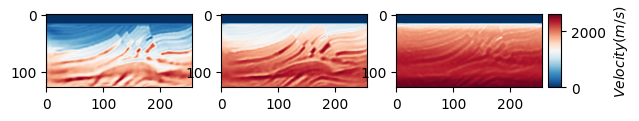

Iteration 1501 ===== loss: 0.00037636051274603233 for data and 12292804.5 for model
Iteration 1502 ===== loss: 0.0003361098497407511 for data and 12258511.75 for model
Iteration 1503 ===== loss: 0.0004028545372420922 for data and 12258234.75 for model
Iteration 1504 ===== loss: 0.00035250591463409364 for data and 12260907.0 for model
Iteration 1505 ===== loss: 0.0003800146951107308 for data and 12272640.0 for model
Iteration 1506 ===== loss: 0.00033967409399338067 for data and 12281071.75 for model
Iteration 1507 ===== loss: 0.000388884378480725 for data and 12243050.0 for model
Iteration 1508 ===== loss: 0.0003561712510418147 for data and 12239754.75 for model
Iteration 1509 ===== loss: 0.00036761763476533815 for data and 12256519.75 for model
Iteration 1510 ===== loss: 0.00033646308293100446 for data and 12255203.0 for model
Iteration 1511 ===== loss: 0.0003570660628611222 for data and 12245624.0 for model
Iteration 1512 ===== loss: 0.00034435877023497596 for data and 12261599.5 for 

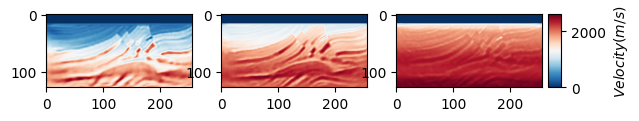

Iteration 1551 ===== loss: 0.0003315634239697829 for data and 12152866.25 for model
Iteration 1552 ===== loss: 0.00037203328975010663 for data and 12168742.0 for model
Iteration 1553 ===== loss: 0.00033701345819281414 for data and 12174077.5 for model
Iteration 1554 ===== loss: 0.00034551149292383343 for data and 12181842.5 for model
Iteration 1555 ===== loss: 0.0003507400251692161 for data and 12156389.25 for model
Iteration 1556 ===== loss: 0.00037442579196067527 for data and 12166758.0 for model
Iteration 1557 ===== loss: 0.0003330387844471261 for data and 12166880.75 for model
Iteration 1558 ===== loss: 0.0003653794774436392 for data and 12168847.75 for model
Iteration 1559 ===== loss: 0.0003462258246145211 for data and 12163754.25 for model
Iteration 1560 ===== loss: 0.00037254671042319387 for data and 12145004.0 for model
Iteration 1561 ===== loss: 0.00033499244455015287 for data and 12150087.0 for model
Iteration 1562 ===== loss: 0.0003509200905682519 for data and 12146561.25 fo

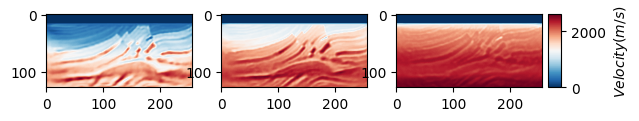

Iteration 1601 ===== loss: 0.00032892268791329116 for data and 12089327.25 for model
Iteration 1602 ===== loss: 0.0003649738064268604 for data and 12066364.0 for model
Iteration 1603 ===== loss: 0.00033414609788451344 for data and 12057306.5 for model
Iteration 1604 ===== loss: 0.00035253793612355366 for data and 12091645.75 for model
Iteration 1605 ===== loss: 0.0003145135997328907 for data and 12086349.75 for model
Iteration 1606 ===== loss: 0.0003455879777902737 for data and 12068812.5 for model
Iteration 1607 ===== loss: 0.0003394359882804565 for data and 12100258.25 for model
Iteration 1608 ===== loss: 0.0003297577059129253 for data and 12085308.0 for model
Iteration 1609 ===== loss: 0.00035030487197218463 for data and 12075250.25 for model
Iteration 1610 ===== loss: 0.00032297717552864924 for data and 12056105.5 for model
Iteration 1611 ===== loss: 0.00033060267742257565 for data and 12074413.75 for model
Iteration 1612 ===== loss: 0.00036893063224852085 for data and 12088154.0 f

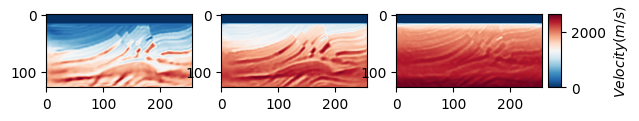

Iteration 1651 ===== loss: 0.00034655487979762256 for data and 12007495.5 for model
Iteration 1652 ===== loss: 0.000312645744998008 for data and 12013771.75 for model
Iteration 1653 ===== loss: 0.00031728119211038575 for data and 12015322.25 for model
Iteration 1654 ===== loss: 0.0003678219291032292 for data and 11983064.75 for model
Iteration 1655 ===== loss: 0.0003188856062479317 for data and 11978021.5 for model
Iteration 1656 ===== loss: 0.00034724120632745326 for data and 12005407.0 for model
Iteration 1657 ===== loss: 0.00031683745328336954 for data and 12011840.25 for model
Iteration 1658 ===== loss: 0.00030910027271602303 for data and 11993485.75 for model
Iteration 1659 ===== loss: 0.00035848870902555063 for data and 11981663.5 for model
Iteration 1660 ===== loss: 0.0003333681379444897 for data and 11979036.25 for model
Iteration 1661 ===== loss: 0.00033378911030013114 for data and 11970331.0 for model
Iteration 1662 ===== loss: 0.00035795704752672464 for data and 11998558.25 

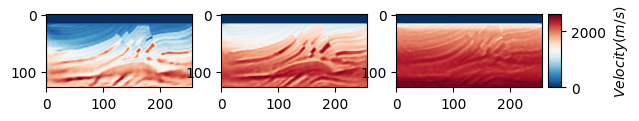

Iteration 1701 ===== loss: 0.00033028266625478864 for data and 11909272.0 for model
Iteration 1702 ===== loss: 0.00033050197089323774 for data and 11934791.25 for model
Iteration 1703 ===== loss: 0.00032113528868649155 for data and 11951478.0 for model
Iteration 1704 ===== loss: 0.0003185081295669079 for data and 11925500.0 for model
Iteration 1705 ===== loss: 0.0003109965691692196 for data and 11931943.75 for model
Iteration 1706 ===== loss: 0.00031095901067601517 for data and 11934430.75 for model
Iteration 1707 ===== loss: 0.00031348758784588426 for data and 11912312.75 for model
Iteration 1708 ===== loss: 0.0003477545833447948 for data and 11926161.0 for model
Iteration 1709 ===== loss: 0.00033405695285182446 for data and 11913259.0 for model
Iteration 1710 ===== loss: 0.0003454517645877786 for data and 11907581.75 for model
Iteration 1711 ===== loss: 0.0003336137015139684 for data and 11908202.25 for model
Iteration 1712 ===== loss: 0.00032161365379579365 for data and 11900749.5 f

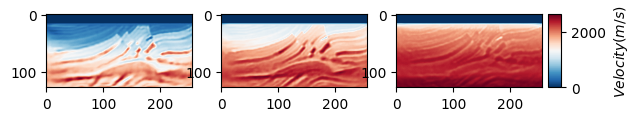

Iteration 1751 ===== loss: 0.0003477650388958864 for data and 11868025.75 for model
Iteration 1752 ===== loss: 0.0003068466030526906 for data and 11840312.5 for model
Iteration 1753 ===== loss: 0.00030710125429322943 for data and 11856488.5 for model
Iteration 1754 ===== loss: 0.0003027936181752011 for data and 11850554.5 for model
Iteration 1755 ===== loss: 0.0003136938830721192 for data and 11825166.5 for model
Iteration 1756 ===== loss: 0.0003326856094645336 for data and 11847842.75 for model
Iteration 1757 ===== loss: 0.00028942854260094464 for data and 11842968.5 for model
Iteration 1758 ===== loss: 0.0003185944879078306 for data and 11830470.0 for model
Iteration 1759 ===== loss: 0.0003373593935975805 for data and 11837063.0 for model
Iteration 1760 ===== loss: 0.0003238445642637089 for data and 11833758.0 for model
Iteration 1761 ===== loss: 0.0002940413178293966 for data and 11846735.25 for model
Iteration 1762 ===== loss: 0.0003080910537391901 for data and 11837162.5 for model

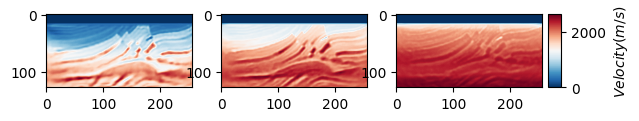

Iteration 1801 ===== loss: 0.0003142471468891017 for data and 11776978.0 for model
Iteration 1802 ===== loss: 0.00029519994131987914 for data and 11777118.0 for model
Iteration 1803 ===== loss: 0.0002921176564996131 for data and 11763657.0 for model
Iteration 1804 ===== loss: 0.0003410941280890256 for data and 11756225.5 for model
Iteration 1805 ===== loss: 0.000289776835415978 for data and 11761292.75 for model
Iteration 1806 ===== loss: 0.00031150965514825657 for data and 11746087.5 for model
Iteration 1807 ===== loss: 0.00029621027351822704 for data and 11758794.5 for model
Iteration 1808 ===== loss: 0.0003266836720285937 for data and 11765602.5 for model
Iteration 1809 ===== loss: 0.00029775483562843874 for data and 11751182.75 for model
Iteration 1810 ===== loss: 0.0003082028197241016 for data and 11754426.5 for model
Iteration 1811 ===== loss: 0.0003234610558138229 for data and 11733113.75 for model
Iteration 1812 ===== loss: 0.000300621752103325 for data and 11745901.0 for model

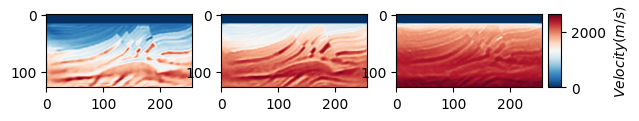

Iteration 1851 ===== loss: 0.0003144923393847421 for data and 11707673.75 for model
Iteration 1852 ===== loss: 0.0002887588561861776 for data and 11692293.0 for model
Iteration 1853 ===== loss: 0.00032267419737763703 for data and 11710587.75 for model
Iteration 1854 ===== loss: 0.0002968970438814722 for data and 11687984.25 for model
Iteration 1855 ===== loss: 0.0002927192981587723 for data and 11700760.5 for model
Iteration 1856 ===== loss: 0.000318004131258931 for data and 11678673.5 for model
Iteration 1857 ===== loss: 0.0002826605414156802 for data and 11684321.5 for model
Iteration 1858 ===== loss: 0.0003099674722761847 for data and 11690459.0 for model
Iteration 1859 ===== loss: 0.0002838068103301339 for data and 11701101.0 for model
Iteration 1860 ===== loss: 0.00029624027956742793 for data and 11676812.0 for model
Iteration 1861 ===== loss: 0.0003087216100539081 for data and 11671500.0 for model
Iteration 1862 ===== loss: 0.0002931462586275302 for data and 11672176.0 for model


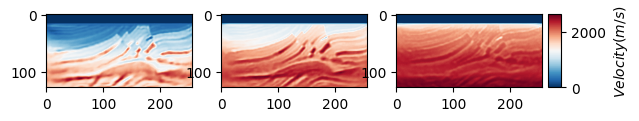

Iteration 1901 ===== loss: 0.0002765661192825064 for data and 11627487.75 for model
Iteration 1902 ===== loss: 0.00030548615904990584 for data and 11614301.0 for model
Iteration 1903 ===== loss: 0.0002879239109461196 for data and 11612808.5 for model
Iteration 1904 ===== loss: 0.0002941142229246907 for data and 11615483.5 for model
Iteration 1905 ===== loss: 0.00029302388429641724 for data and 11639662.25 for model
Iteration 1906 ===== loss: 0.0003082142138737254 for data and 11595870.25 for model
Iteration 1907 ===== loss: 0.00028353829839034006 for data and 11608106.75 for model
Iteration 1908 ===== loss: 0.00028165812545921654 for data and 11607118.25 for model
Iteration 1909 ===== loss: 0.0003080275491811335 for data and 11607264.0 for model
Iteration 1910 ===== loss: 0.0002730138076003641 for data and 11601901.5 for model
Iteration 1911 ===== loss: 0.0002943069048342295 for data and 11597788.25 for model
Iteration 1912 ===== loss: 0.0003086645738221705 for data and 11606783.25 for

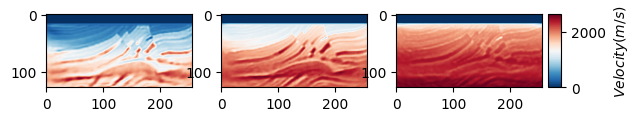

Iteration 1951 ===== loss: 0.00029294222622411326 for data and 11546262.75 for model
Iteration 1952 ===== loss: 0.00027354580379324034 for data and 11567180.5 for model
Iteration 1953 ===== loss: 0.0002754310626187362 for data and 11539376.25 for model
Iteration 1954 ===== loss: 0.00030227417300920933 for data and 11543101.25 for model
Iteration 1955 ===== loss: 0.0002922061976278201 for data and 11539475.75 for model
Iteration 1956 ===== loss: 0.0002738345574471168 for data and 11530302.0 for model
Iteration 1957 ===== loss: 0.00028011850372422487 for data and 11531468.75 for model
Iteration 1958 ===== loss: 0.00030850004259264097 for data and 11531524.0 for model
Iteration 1959 ===== loss: 0.0002646393477334641 for data and 11556620.5 for model
Iteration 1960 ===== loss: 0.00030954069370636716 for data and 11517087.5 for model
Iteration 1961 ===== loss: 0.00026700728631112725 for data and 11528937.75 for model
Iteration 1962 ===== loss: 0.0002894588906201534 for data and 11531100.25 

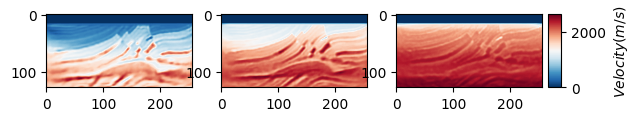

CPU times: user 40min 7s, sys: 18min 44s, total: 58min 52s
Wall time: 58min 31s


In [13]:
%%time
log_dir = summary_path + "/" + variable_value
#clear_dir(log_dir)                                                
writer = SummaryWriter(log_dir=log_dir)

def plotimg(a,b,c):
    fig, ax = plt.subplots(1,3)
    im0 = ax[0].imshow(a.squeeze(0).detach().cpu(), cmap="RdBu_r") 
    im1 = ax[1].imshow(b.squeeze(0).detach().cpu(), cmap="RdBu_r") 
    im2 = ax[2].imshow(c.squeeze(0).detach().cpu(), cmap="RdBu_r")
    points = ax[2].get_position().get_points()
    dy = points[1, 1] - points[0, 1]

    cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
    cax.yaxis.set_ticks_position("right")
    cbar = fig.colorbar(im1, cax=cax, orientation="vertical",extend="neither", label="$Velocity (m/s)$")
    #plt.show()
    return fig
    
for iter in range(ITERATION):
    loss_data, mp_sq, ms_sq,mrho_sq, transfomerdecoder  = train_fun(
        Physics=Physics, 
        transfomerdecoder=transfomerdecoder,
        deepwave_size=DEEPWAVE_SIZE,
        rho_initial=rho_initial,
        vx_initial=vp_initial,
        vy_initial=vs_initial,
        d_obs_vx=d_obs_vx ,
        d_obs_vy=d_obs_vy ,
        input_vx=input_vx,
        input_vy=input_vy,
        optim_transfomerdecoder=optim_transfomerdecoder, 
        criteria=criteria,
        mini_batches = MINI_BATCHES,
        src_loc=src_loc, 
        rec_loc=rec_loc, 
        src=src,
        inpa=inpa,
        submarine=submarine,
        vp_scale=vp_scale,
        vs_scale=vs_scale,
        rho_scale=rho_scale,
        submarine_deep=submarine_deep,
        submarine_vp=submarine_vp,
        submarine_vs=submarine_vs,
        submarine_rho=submarine_rho)

    all_loss_data.append(loss_data) 
    

    with torch.no_grad():
        all_loss_vx_model.append(
            criteria(mp_sq, vp).item()
        )
        all_loss_vy_model.append(
            criteria(ms_sq, vs).item()
        )
        all_loss_rho_model.append(
            criteria(mrho_sq, rho).item()
        )
        all_loss_model.append(
            criteria(mp_sq, vp).item() + criteria(ms_sq, vs).item()+ criteria(mrho_sq, rho).item()
        )
        
    
    if (iter+1)%PRINT_FREQ == 0:
        print(f"Iteration {iter + 1} ===== loss: {all_loss_data[-1]} for data and {all_loss_model[-1]} for model")
    if (iter+1)%BOARDSHOW_FREQ == 0:
        writer.add_scalar('Loss/Data', loss_data, iter+1)
        writer.add_scalar('Loss/model vx', all_loss_vx_model[-1], iter+1)
        writer.add_scalar('Loss/model vy', all_loss_vy_model[-1], iter+1)
        writer.add_scalar('Loss/model rho', all_loss_rho_model[-1], iter+1)
        writer.add_scalar('Loss/model', all_loss_model[-1], iter+1)
        writer.add_figure("compare/train", plotimg(mp_sq,ms_sq,mrho_sq), iter+1, close=True)
        fig, ax = plt.subplots(1,3)
        im0 = ax[0].imshow(mp_sq.squeeze(0).detach().cpu(), 
                          cmap="RdBu_r") 
        im1 = ax[1].imshow(ms_sq.squeeze(0).detach().cpu(), 
                          cmap="RdBu_r") 
        im2 = ax[2].imshow(mrho_sq.squeeze(0).detach().cpu(), 
                          cmap="RdBu_r") 
        points = ax[1].get_position().get_points()
        dy = points[1, 1] - points[0, 1]

        cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
        cax.yaxis.set_ticks_position("right")
        cbar = fig.colorbar(im1, cax=cax, orientation="vertical", 
                            extend="neither", label="$Velocity (m/s)$"
                            )
        plt.show()
    if (iter+1)%SAVE_FREQ == 0:
        estimatedv = {"vp_est": mp_sq,"vs_est": ms_sq,"rho_est": mrho_sq,"data_loss":all_loss_data}    
        estimatedv_name = f"{model_path}/{iter+1}.pth"
        torch.save(estimatedv, estimatedv_name)
    scheduler_transfomerdecoder.step()  

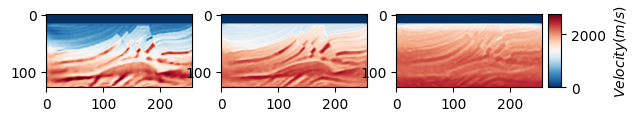

In [14]:
fig, ax = plt.subplots(1,3)
im0 = ax[0].imshow(mp_sq.squeeze(0).detach().cpu(), 
                  cmap="RdBu_r", vmin=vp.min(), 
           vmax=vp.max()) 
im1 = ax[1].imshow(ms_sq.squeeze(0).detach().cpu(), 
                  cmap="RdBu_r", vmin=vs.min(), 
           vmax=vs.max()) 
im2 = ax[2].imshow(mrho_sq.squeeze(0).detach().cpu(), 
                  cmap="RdBu_r", vmin=rho.min(), 
           vmax=rho.max()) 
points = ax[1].get_position().get_points()
dy = points[1, 1] - points[0, 1]

cax = fig.add_axes([0.91, points[0, 1], 0.02, dy])
cax.yaxis.set_ticks_position("right")
cbar = fig.colorbar(im1, cax=cax, orientation="vertical", 
                    extend="neither", label="$Velocity (m/s)$")
plt.savefig(Fig_path + f"/inverse_result.pdf", bbox_inches='tight', dpi=900)
plt.show()